# yfinance

[yfinance](https://pypi.org/project/yfinance/) represents an effective tool for accessing historic stock market data from the Yahoo Finance API, after the original API was removed (this happened a number of years ago). I think Quandl also used to provide some stock data for free (although no longer for the primary exchanges), and the Alphavantage API is still an option - but it is less _pythonic_ (the promise of yfinance).

Thus, we'll explore this source of stock data to see what we can do with it. At the moment, I'm going to do a first pass using pandas. I am planning to see how we can work with the data using polars in the future, as I think there may be some speed benefits there if we start looking at data on a more granular temporality.

### Imports

In [144]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import datetime
import polars as pl

### Scraping Market Cap Data

Let's grab some of the major market cap companies from the wikipedia page. We'll manually put the tickers in later, but we could try to pull the tickers in via scraping as well.

In [8]:
resp = requests.get("https://en.wikipedia.org/wiki/List_of_public_corporations_by_market_capitalization")

In [11]:
response = BeautifulSoup(resp.content, "html.parser")
tables = response.find_all('table', {'class':"wikitable"})[1]
df = pd.read_html(str(tables))
df = pd.DataFrame(df[0])
print(df.columns)

In [69]:
extract_largest_2q = df["Second quarter.1"].str.extract(r'(^[\w\s]+)\s+\d').squeeze().str.rstrip()
print(extract_largest_2q)

0                 Apple
1             Microsoft
2              Alphabet
3                Amazon
4                Nvidia
5                 Tesla
6    Berkshire Hathaway
7                  Meta
8                  TSMC
9                  Visa
Name: 0, dtype: object
<class 'pandas.core.series.Series'>


### Build List of 10 Tickers

In [110]:
"""
Note that, for Yahoo Finance, BRK.A is BRK-A. Not sure of a good way to deal with share classes without trying multiple variants!
"""
ticker_list = [
    "AAPL",
    "MSFT",
    "GOOGL",
    "AMZN",
    "NVDA",
    "TSLA",
    "BRK-A",
    "META",
    "TSM",
    "V",
]

We can get the data for either a single ticker, or multiple tickers in one pass. The access is similar though slightly more complicated if we grab data for multiple tickers, because we are dealing with higher dimensions.

Note that, at present, the .info() method seems to be failing (see the discussion [here](https://github.com/ranaroussi/yfinance/issues/1729)). The relevant price methods do still appear to function.

In [85]:
"""
We can get a single ticker (e.g. AAPL) as follows
"""

aapl = yf.Ticker(ticker = ticker_list[0])
aapl.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099319,0.099751,0.099319,0.099319,469033600,0.00,0.0
1980-12-15 00:00:00-05:00,0.094569,0.094569,0.094137,0.094137,175884800,0.00,0.0
1980-12-16 00:00:00-05:00,0.087659,0.087659,0.087228,0.087228,105728000,0.00,0.0
1980-12-17 00:00:00-05:00,0.089387,0.089818,0.089387,0.089387,86441600,0.00,0.0
1980-12-18 00:00:00-05:00,0.091978,0.092410,0.091978,0.091978,73449600,0.00,0.0
...,...,...,...,...,...,...,...
2023-11-08 00:00:00-05:00,182.110085,183.208629,181.351076,182.649368,49340300,0.00,0.0
2023-11-09 00:00:00-05:00,182.719278,183.877740,181.570782,182.169998,53763500,0.00,0.0
2023-11-10 00:00:00-05:00,183.970001,186.570007,183.529999,186.399994,66133400,0.24,0.0


In [90]:
aapl_prices = aapl.history(period="max")["Close"]

<AxesSubplot:xlabel='Date'>

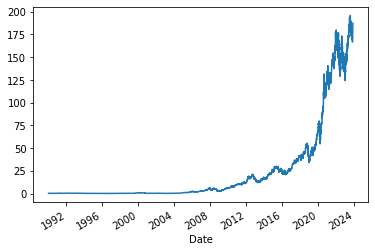

In [98]:
aapl_prices["1990-01-01":].plot()

If we want to grab a number of tickers at once, we can pass them as a single string argument to the download() function, as follows

In [113]:
today = str(datetime.date.today())
top10 = yf.download(" ".join(ticker_list), start="2005-01-01", end=today)

[*********************100%%**********************]  10 of 10 completed


In [112]:
"""
If we called download() with group_by='ticker', then we can view individual ticker info like this. 
However, it's not the easiest if we want to work with a single value, e.g. Adj Close. So we'll unod that and carry on without that group_by.
"""
top10["MSFT"]["Adj Close"]

Date
2005-01-03     18.732998
2005-01-04     18.803049
2005-01-05     18.761024
2005-01-06     18.740004
2005-01-07     18.683956
                 ...    
2023-11-07    360.529999
2023-11-08    363.200012
2023-11-09    360.690002
2023-11-10    369.670013
2023-11-13    366.679993
Name: Adj Close, Length: 4749, dtype: float64

In [127]:
prices = top10["Adj Close"]
prices["TSLA"].notna()

Date
2005-01-03    False
2005-01-04    False
2005-01-05    False
2005-01-06    False
2005-01-07    False
              ...  
2023-11-07     True
2023-11-08     True
2023-11-09     True
2023-11-10     True
2023-11-13     True
Name: TSLA, Length: 4749, dtype: bool

Now we can see from the above dataframe (and we knew it anyway!) that not all of the companies have a history going back to January 2005. So we want to drop dates that don't have a full history.

In fact, we can quickly check the first date for which we have TSLA data by running a quick Polars cell. It was going to be too complicated to figure out the pandas syntax to do this, and I think it is a good indication of some of the strengths of not having an index to deal with!

In [139]:
prices2 = pl.from_pandas(prices, include_index=True)
(prices2.
    filter(pl.col("TSLA").is_not_null())
    .select(pl.col("Date"))
    .min()
)

Date
datetime[ns]
2010-06-29 00:00:00


In [141]:
prices = prices.dropna(how="any")
prices.head()

,AAPL,AMZN,BRK-A,GOOGL,META,MSFT,NVDA,TSLA,TSM,V
Date,,,,,,,,,,
2012-05-18,16.056875,10.6925,119850.0,15.025025,38.230000,23.619810,2.770626,1.837333,10.109581,25.950731
2012-05-21,16.992346,10.9055,120220.0,15.368118,34.029999,24.007153,2.818791,1.918000,10.208695,26.775513
2012-05-22,16.861860,10.7665,120550.0,15.035035,31.000000,24.015221,2.784388,2.053333,10.194539,27.275454
2012-05-23,17.273289,10.8640,120455.0,15.251752,32.000000,23.490696,2.853195,2.068000,9.967992,27.455158
2012-05-24,17.114658,10.7620,120217.0,15.106607,33.029999,23.458416,2.777506,2.018667,9.883039,27.593386


<AxesSubplot:xlabel='Date'>

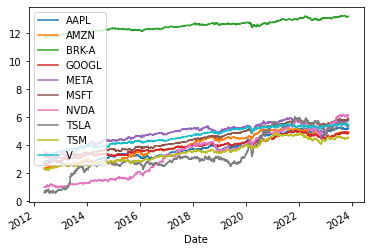

In [147]:
"""
We'll plot the log of the prices, because BRK-A makes a mess of things
"""
np.log(prices).plot()

So we have prices for the 10 stocks. But there's not a great deal we can do with prices in their absolute form: as we can see by the incomparability of the price chart above. What does it mean that BRK-A sits way above all the other price series?

To learn more, we need to think about returns. Thats's the next thing to calculate.

In [165]:
"""
calculate the daily log return for each stock on each day
"""
returns = np.log(1+prices.pct_change()).dropna(how='any')
returns

,AAPL,AMZN,BRK-A,GOOGL,META,MSFT,NVDA,TSLA,TSM,V
Date,,,,,,,,,,
2012-05-21,0.056626,0.019725,0.003082,0.022578,-0.116378,0.016266,0.017235,0.042968,0.009756,0.031288
2012-05-22,-0.007709,-0.012828,0.002741,-0.021912,-0.093255,0.000336,-0.012280,0.068181,-0.001388,0.018499
2012-05-23,0.024107,0.009015,-0.000788,0.014311,0.031749,-0.022083,0.024411,0.007118,-0.022473,0.006567
2012-05-24,-0.009226,-0.009433,-0.001978,-0.009562,0.031680,-0.001375,-0.026886,-0.024145,-0.008559,0.005022
2012-05-25,-0.005374,-0.010978,-0.005982,-0.020299,-0.034497,-0.000344,0.023665,-0.015644,0.001432,-0.003345
...,...,...,...,...,...,...,...,...,...,...
2023-11-07,0.014347,0.021031,-0.002225,0.005513,0.009518,0.011157,0.004449,0.013184,-0.002054,0.005243
2023-11-08,0.005868,-0.004424,0.002624,0.006621,0.003007,0.007379,0.013380,-0.000315,-0.004447,-0.001393
2023-11-09,-0.002628,-0.010471,0.002967,-0.012210,0.002405,-0.006935,0.008041,-0.056160,-0.004139,-0.009350


We'll take the daily data and find the mean of the annualised returns for each stock.

<AxesSubplot:>

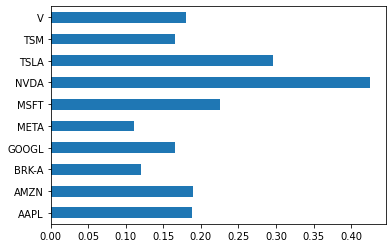

In [167]:
"""
calculate the mean daily return, on an annualised basis. there are 252 trading days in a year, and we divid this by the number of days of data we have to get the number of years for the calculation
"""
mean_returns = (1 + returns).prod() ** (252 / returns.count()) - 1
mean_returns.plot.barh()

We can see from the above data that NVDA and TSLA have considerably higher mean returns over our sample period than most other stocks.

But knowing only the mean return for a stock is of limited value. Maybe we would say that a stock with higher mean return is going to have higher expected returns (although this is an oversimplification and is too easy as a method of return prediction).